# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 1

## Predição de séries temporais empregando vários tipos de modelos
#### Parcialmente baseado em https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
## Caso de estudo: Mercado de ações (NYSE: The New York Stock Exchange)
#### Parcialmente baseado em https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Rafael Ito

### 6.1. Importações e definições

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat
from multiprocessing import cpu_count

# Specifi imports
from keras.models import Model, Sequential
#from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Steps")
    plt.ylabel("Time Series Values")
    plt.title("Sunspots Time Series")
    plt.grid(True)

Using TensorFlow backend.


### 6.2. Carregando a base de dados e apresentando sua composição

In [2]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

# import all stock prices 
#df = pd.read_csv("C:/IA353/prices-split-adjusted.csv", index_col = 0)
!wget -nc -q https://raw.githubusercontent.com/ito-rafael/IA353A-NeuralNetworks-1s2020/master/EFC3/Q6/prices-split-adjusted.csv
#col_names = ['date', 'symbol', 'open', 'close', 'low', 'high', 'volume']
#df = pd.read_csv('/content/prices-split-adjusted.csv', names=col_names, sep=',', index_col=0)
df = pd.read_csv('/content/prices-split-adjusted.csv', index_col=0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['ROK', 'TIF', 'RHT', 'GILD', 'PX', 'MCHP', 'SO', 'WAT', 'LUV', 'UNH']


,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


### 6.3. Exibindo o comportamento temporal de várias séries associadas à ação EQIX

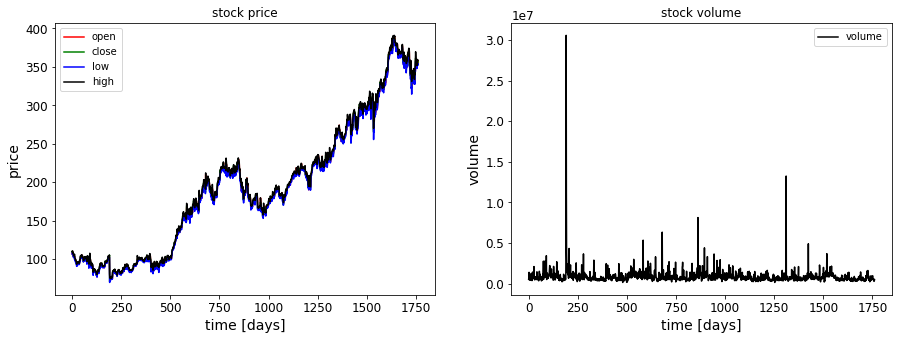

In [3]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

### 6.4. Escolha do preço de fechamento da ação EQIX e preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste
#### Cabe comentar que os dados de teste não deveriam participar de nenhuma etapa de pré-processamento, pois, assim, têm o potencial de interferir no andamento do treinamento, desvirtuando o seu papel de apenas servirem para teste de desempenho. Cometeremos essa "mancada" metodológica para despertar o(a) aluno(a) para a questão.

In [4]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = np.array(stock) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    # Choice of the close behavior
    
    x_train = data[:train_set_size,:-1,1]
    y_train = data[:train_set_size,-1,1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,1]
    
    x_test = data[train_set_size+valid_set_size:,:-1,1]
    y_test = data[train_set_size+valid_set_size:,-1,1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P1_x_train.txt', x_train)
    np.savetxt('Q6P1_y_train.txt', y_train)
    np.savetxt('Q6P1_x_valid.txt', x_valid)
    np.savetxt('Q6P1_y_valid.txt', y_valid)
    np.savetxt('Q6P1_x_test.txt', x_test)
    np.savetxt('Q6P1_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
print('Chosen stock is EQIX')
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols[1])

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

Chosen stock is EQIX
df_stock.columns.values =  close
x_train.shape =  (1393, 20)
y_train.shape =  (1393, 1)
x_valid.shape =  (174, 20)
y_valid.shape =  (174, 1)
x_test.shape =  (174, 20)
y_test.shape =  (174, 1)


### 6.5. Visualização do comportamento da série temporal normalizada

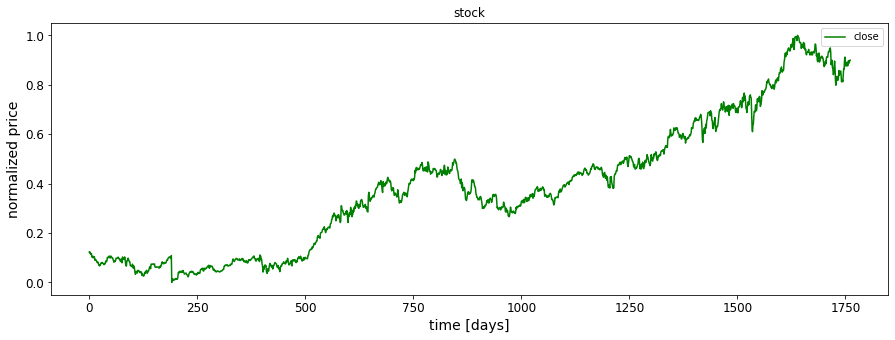

In [5]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.close.values, color='green', label='close')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.show()

### 6.6. Sintetizando um preditor linear

In [6]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[-1.73993876e-02 -7.50066948e-04 -1.72042605e-02 -3.09133810e-03
  7.19680083e-02 -4.14608411e-02  6.27850574e-03  3.20712481e-02
 -5.12410805e-02 -4.49534424e-02  7.63970457e-02  2.38739465e-03
 -2.37630945e-02  4.03452307e-02  1.52671193e-03 -2.65006693e-02
  6.09614856e-02 -2.34004550e-02 -4.62112083e-03  9.62510603e-01
  0.00000000e+00]


#### 6.6.1. Visualização do desempenho do preditor linear

In [7]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
8.2815338977819e-05
EQM final de validação após o término do treinamento - Preditor Linear
0.00027770088993386247
EQM final de teste após o término do treinamento - Preditor Linear
0.00021231229767131773


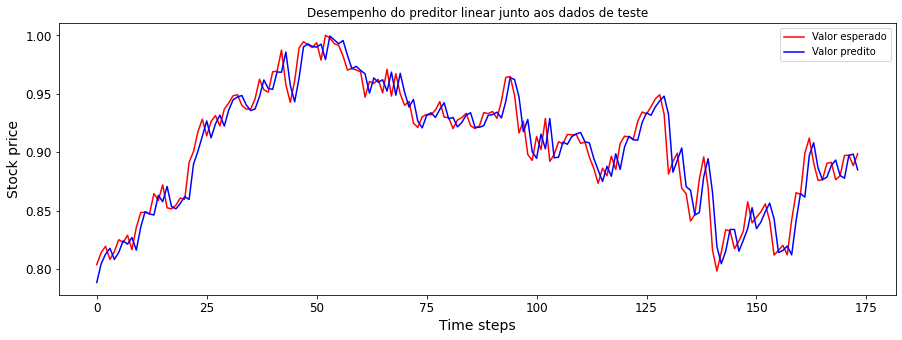

In [8]:
y_pred = X.dot(w)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.7. Sintetizando um preditor não-linear MLP

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
EPOCHS = 20
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/20
44/44 [==============================] - 0s 6ms/step - loss: 0.0141 - val_loss: 0.0176
Epoch 2/20
44/44 [==============================] - 0s 3ms/step - loss: 5.2879e-04 - val_loss: 0.0064
Epoch 3/20
44/44 [==============================] - 0s 4ms/step - loss: 3.6791e-04 - val_loss: 0.0036
Epoch 4/20
44/44 [==============================] - 0s 3ms/step - loss: 3.1558e-04 - val_loss: 0.0036
Epoch 5/20
44/44 [==============================] - 0s 4ms/step - loss: 2.8513e-04 - val_loss: 0.0028
Epoch 6/20
44/44 [==============================] - 0s 3ms/step - loss: 2.4944e-04 - val_loss: 0.0026
Epoch 7/20
44/44 [==============================] - 0s 3ms/step - loss: 2.2248e-04 - val_loss: 0.0015
Epoch 8/20
44/44 [==============================] - 0s 3ms/step - loss: 2.1365e-04 - val_loss: 0.0019
Epoch 9/20
44/44 [==============================] - 0s 3ms/step - loss: 1.7862e-04 - val_loss: 0.0011
Epoch 10/20
44/44 [==============================] - 0s 3ms/step - loss: 1.6849e-04 - 

In [11]:
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2688      
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________


#### 6.7.1. Carregando o modelo com o menor MAPE para o preditor MLP

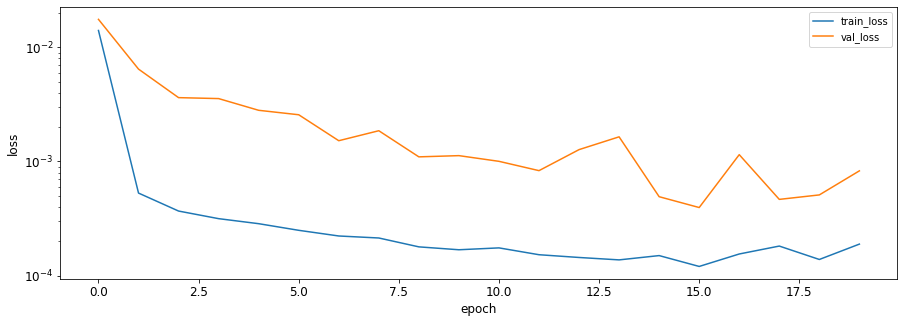

In [12]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.7.2. Visualização do desempenho do preditor MLP

In [13]:
#weights = model_MLP.get_weights()
#print(weights)
#print(model_MLP.weights)
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
0.00012126912609849167
EQM final de validação após o término do treinamento - Preditor MLP
0.00039494235099503584
EQM final de teste após o término do treinamento - Preditor MLP
0.0008925096885209801


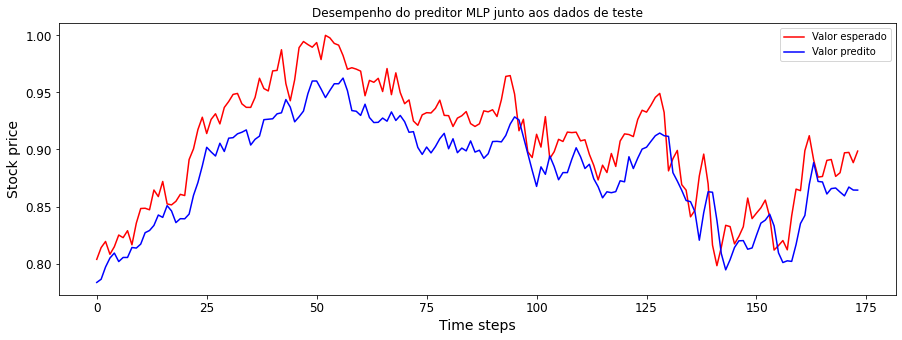

In [14]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.8. Sintetizando um preditor não-linear Simple RNN

In [15]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_RNN1.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN1_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN1.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(1393, 20, 1)
(1393, 1)
(174, 20, 1)
(174, 1)
(174, 20, 1)
(174, 1)
Epoch 1/20
44/44 [==============================] - 1s 33ms/step - loss: 0.0199 - val_loss: 0.0026
Epoch 2/20
44/44 [==============================] - 1s 27ms/step - loss: 9.8488e-04 - val_loss: 0.0025
Epoch 3/20
44/44 [==============================] - 1s 28ms/step - loss: 7.7301e-04 - val_loss: 0.0023
Epoch 4/20
44/44 [==============================] - 1s 27ms/step - loss: 7.1213e-04 - val_loss: 0.0030
Epoch 5/20
44/44 [==============================] - 1s 27ms/step - loss: 6.7540e-04 - val_loss: 0.0036
Epoch 6/20
44/44 [==============================] - 1s 27ms/step - loss: 6.3687e-04 - val_loss: 0.0025
Epoch 7/20
44/44 [==============================] - 1s 27ms/step - loss: 6.0069e-04 - val_loss: 0.0026
Epoch 8/20
44/44 [==============================] - 1s 27ms/step - loss: 5.5675e-04 - val_loss: 0.0024
Epoch 9/20
44/44 [==============================] - 1s 27ms/step - loss: 5.2492e-04 - val_loss: 0.0022
Epoch 10/

In [16]:
model_RNN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


#### 6.8.1. Carregando o modelo com o menor MAPE para o preditor não-linear Simple RNN

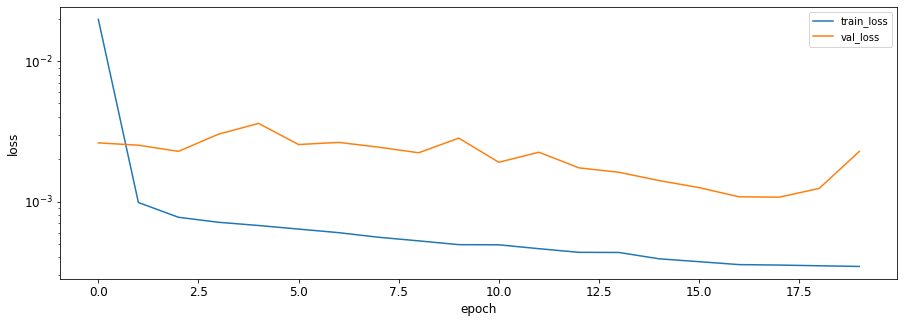

In [17]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN1.load_weights("model_RNN1_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.8.2. Visualização do desempenho do preditor não-linear Simple RNN junto aos dados de teste

In [18]:
print('EQM final de treinamento após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Simple RNN
0.0003596383095586331
EQM final de validação após o término do treinamento - Preditor Simple RNN
0.0010747950124500114
EQM final de teste após o término do treinamento - Preditor Simple RNN
0.006695130832401431


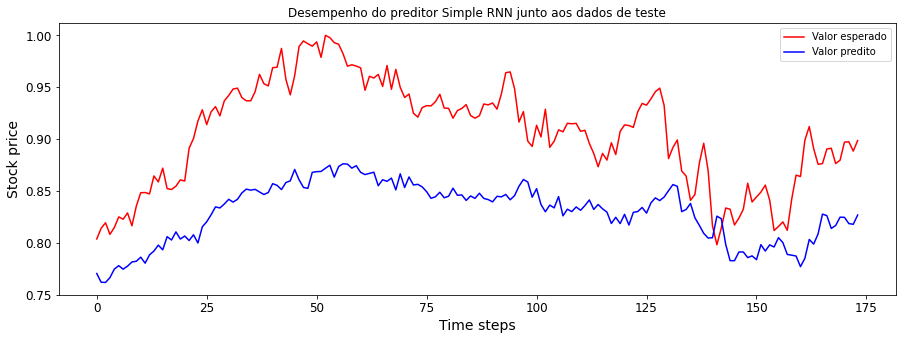

In [19]:
y_pred = model_RNN1.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor Simple RNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.9. Sintetizando um preditor não-linear com bloco LSTM GRU

In [20]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN2 = keras.models.Sequential([
    keras.layers.GRU(seq_len, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(seq_len, return_sequences=True),
    keras.layers.Dense(1)
])

model_RNN2.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN2_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN2.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(1393, 20, 1)
(1393, 1)
(174, 20, 1)
(174, 1)
(174, 20, 1)
(174, 1)
Epoch 1/20
44/44 [==============================] - 1s 18ms/step - loss: 0.0202 - val_loss: 0.0465
Epoch 2/20
44/44 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0227
Epoch 3/20
44/44 [==============================] - 0s 7ms/step - loss: 0.0037 - val_loss: 0.0146
Epoch 4/20
44/44 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0093
Epoch 5/20
44/44 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0073
Epoch 6/20
44/44 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0061
Epoch 7/20
44/44 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 8/20
44/44 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 9/20
44/44 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 10/20
44/44 [==============================

In [21]:
model_RNN2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           21        
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________


#### 6.9.1. Carregando o modelo com o menor MAPE para o preditor não-linear com bloco LSTM GRU

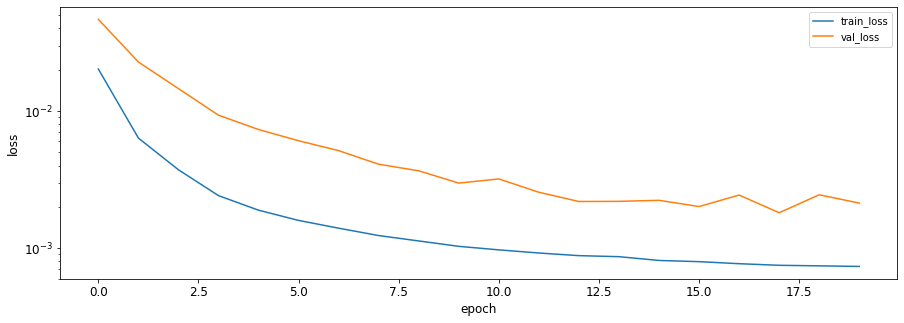

In [22]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN2.load_weights("model_RNN2_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.9.2. Visualização do desempenho do preditor não-linear com bloco LSTM GRU junto aos dados de teste

In [23]:
print('EQM final de treinamento após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_train,y_train)
print('EQM final de validação após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_valid,y_valid)
print('EQM final de teste após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_test,y_test)

EQM final de treinamento após o término do treinamento - Preditor LSTM GRU
44/44 [==============================] - 0s 3ms/step - loss: 7.5924e-04
EQM final de validação após o término do treinamento - Preditor LSTM GRU
6/6 [==============================] - 0s 3ms/step - loss: 0.0018
EQM final de teste após o término do treinamento - Preditor LSTM GRU
6/6 [==============================] - 0s 3ms/step - loss: 0.0019


0.0019320871215313673

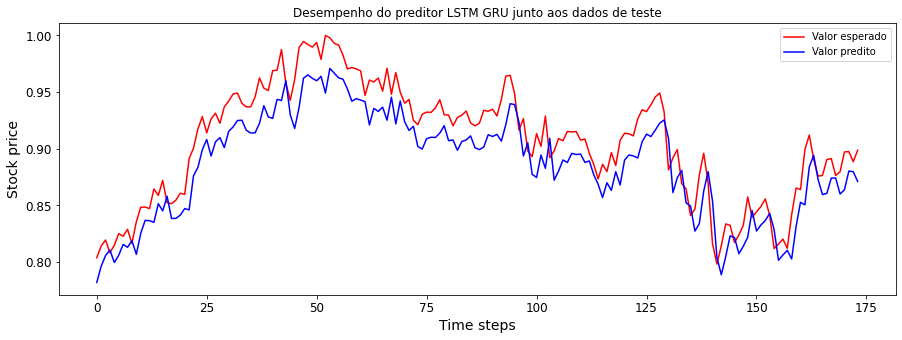

In [24]:
y_pred = model_RNN2.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred[:,seq_len - 1], color='blue', label='Valor predito')
plt.title('Desempenho do preditor LSTM GRU junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.10. Sintetizando um preditor não-linear CNN 1D
#### Parcialmente baseado em https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/1_CNN_dilated.ipynb

In [25]:
from keras.layers import Conv1D, Dense, Flatten
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
model_CNN = Sequential()
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(seq_len, 1)))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(1, activation='linear'))
model_CNN.compile(optimizer='Adam', loss='mse')

In [26]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 20, 5)             15        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 5)             55        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 20, 5)             55        
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [27]:
from keras.callbacks import ModelCheckpoint

In [28]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_CNN_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_CNN.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Train on 1393 samples, validate on 174 samples
Epoch 1/20
1393/1393 [==============================] - 1s 557us/step - loss: 0.0372 - val_loss: 0.0476
Epoch 2/20
1393/1393 [==============================] - 0s 120us/step - loss: 0.0046 - val_loss: 0.0132
Epoch 3/20
1393/1393 [==============================] - 0s 125us/step - loss: 7.4578e-04 - val_loss: 0.0065
Epoch 4/20
1393/1393 [==============================] - 0s 132us/step - loss: 6.3263e-04 - val_loss: 0.0044
Epoch 5/20
1393/1393 [==============================] - 0s 119us/step - loss: 5.5722e-04 - val_loss: 0.0032
Epoch 6/20
1393/1393 [==============================] - 0s 121us/step - loss: 5.3576e-04 - val_loss: 0.0027
Epoch 7/20
1393/1393 [==============================] - 0s 124us/step - loss: 5.2514e-04 - val_loss: 0.0028
Epoch 8/20
1393/1393 [==============================] - 0s 120us/step - loss: 5.0950e-04 - val_loss: 0.0020
Epoch 9/20
1393/1393 [==============================] - 0s 137us/step - loss: 4.9443e-04 - val_lo

#### 6.10.1. Carregando o modelo com o menor MAPE para o preditor CNN

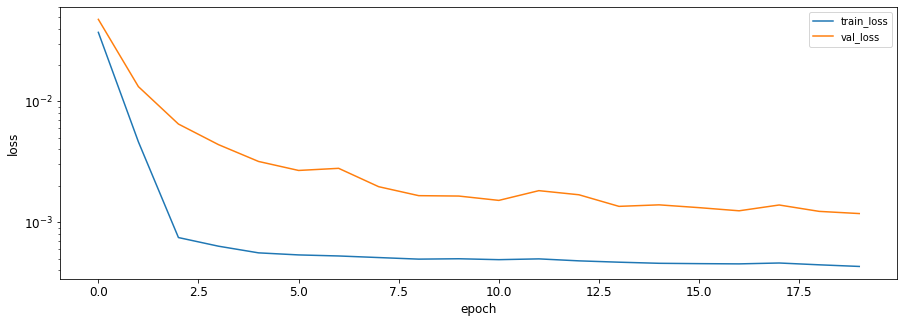

In [29]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_CNN.load_weights("model_CNN_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.10.2. Visualização do desempenho do preditor CNN junto aos dados de teste

In [30]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.0004326646142520816
EQM final de validação após o término do treinamento - Preditor CNN
0.0011781349358997001
EQM final de teste após o término do treinamento - Preditor CNN
0.004893203263910455


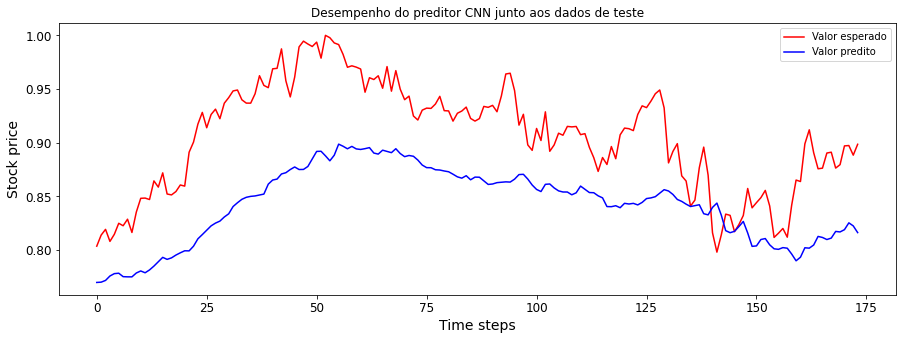

In [31]:
y_pred = model_CNN.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor CNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

## Atividades práticas

### 6.1.1. Resumo geral


Atividade:  
Forneça o notebook devidamente executado, contendo, ao final, um resumo geral do que foi trabalhado em cada seção.

Resposta:  
- 6.1: 
  - Importação de módulos

- 6.2: 
  - Carregamento dos dados NYSE (The New York Stock Exchange)

- 6.3: 
  - Visualização dos dados referente a Equinix Inc (EQIX)
  - Os dados estão estruturados em 7 colunas.
  - No primeiro gráfico temos 4 plots:
    - eixo X: dias (coluna "date")
    - eixo Y: valores das colunas "open", "close", "low" e "high"
  - No segundo gráfico, temos:
    - eixo X: dias (coluna "date")
    - eixo Y: valor da coluna "volume"

- 6.4:
  - Normalização dos dados usando min_max_scaler (scikit-learn)
  - Partição dos dados em treino, validação e teste
  - Função para formação dos dados de treino, validação e teste dado o tamanho da sequência desejada, seq_len (número de dias anteriores à predição)

- 6.5:
  - Gráfico com os valores do símbolo EQIX considerando a coluna "close" normalizados entre 0 e 1

- 6.6:
  - Sintetização de um preditor linear usando a classe LinearRegression da biblioteca scikit-learn
  - Impressão dos valores dos pesos do preditor linear
  - Cálculo do EQM de treinamento, validação e teste após o fim do treinamento
  - Plot dos valores esperados e preditos considerando o conjunto de teste

- 6.7
  - Sintetização de um preditor não-linear usando uma rede MLP de 4 camadas densas
    - camadas: entrada, 128 neurônios, 64 neurônios e 1 neurônio (saída)
    - treinamento: 20 épocas, otimizador Adam, loss MSE
  - Resumo do modelo mostrando camadas e número de parâmetros
  - Plot da loss de treino e validação ao longo das épocas
  - Cálculo do EQM de treinamento, validação e teste após o fim do treinamento
  - Plot dos valores esperados e preditos considerando o conjunto de teste

- 6.8:
  - Sintetização de um preditor não-linear usando uma rede neural recorrente
    - camadas: duas camadas SimpleRNN (com 20 neurônios) e uma camada densa de saída
    - treinamento: 20 épocas, otimizador Adam, loss MSE
  - Resumo do modelo mostrando camadas e número de parâmetros
  - Plot da loss de treino e validação ao longo das épocas
  - Cálculo do EQM de treinamento, validação e teste após o fim do treinamento
  - Plot dos valores esperados e preditos considerando o conjunto de teste

- 6.9:
  - Sintetização de um preditor não-linear usando o bloco GRU (semelhante ao bloco LSTM)
    - camadas: duas camadas GRU e uma camada densa de saída
    - treinamento: 20 épocas, otimizador Adam, loss MSE
  - Resumo do modelo mostrando camadas e número de parâmetros
  - Plot da loss de treino e validação ao longo das épocas
  - Cálculo do EQM de treinamento, validação e teste após o fim do treinamento
  - Plot dos valores esperados e preditos considerando o conjunto de teste

- 6.10:
  - Sintetização de um preditor não-linear usando camadas convolucionais
    - camadas: três camadas convolucionais Conv1D (kernel 2, relu, stride=1) e uma camada densa de saída
    - treinamento: 20 épocas, otimizador Adam, loss MSE
  - Resumo do modelo mostrando camadas e número de parâmetros
  - Plot da loss de treino e validação ao longo das épocas
  - Cálculo do EQM de treinamento, validação e teste após o fim do treinamento
  - Plot dos valores esperados e preditos considerando o conjunto de teste


### 6.1.2. Preditor linear

Atividade: Com o foco no desempenho do preditor linear, procure apresentar argumentos capazes de sustentar o fato de a predição  proposta corresponder basicamente a uma versão atrasada da própria série temporal.

Resposta:  
Analisando os pesos do preditor linear, podemos ver que o peso referente a entrada mais recente apresenta o maior peso dentre todos. Isso quer dizer que a última entrada vai ser a mais relevante para a predição do próximo passo. Isso faz com que a predição se assemelhe bastante ao valor imediatamente anterior, isto é, isso faz com que a predição seja semelhante a uma versão atrasada da série.

### 6.1.3. Preditor não-linear

Atividade: Embora seja possível obter, com os modelos de predição não-lineares, um desempenho similar àquele do preditor linear (isso não é solicitado ao aluno, no entanto), explique por que o preditor linear é tão competente nesta tarefa de predição específica.

Resposta:  
Os dados tratados nesta série temporal se refere aos preços de ações da bolsa de Nova York. Esses valores são dependentes de inúmeros fatores externos e que na maioria das vezes são imprevisíveis. Um exemplo bastante atual é a pandemia de Covid-19. Isso afetou o valor de diversas moedas e valores de ações e foi algo completamente não prevísivel se considerarmos um período de menos de um ano atrás. Assim, conhecer valores passados da série, pode não ser suficiente para predizer valores futuros. O que é de se esperar, pois caso contrário, qualquer pessoa com conhecimentos intermediários ou até básicos de machine learning estaria milionário. Para concluir, como o preditor linear é o mais simples de todos, tendendo a produzir um valor atrasado da série, como explicado no item anterior, seu desempenho se torna bom para esse caso e esses dados. Como o valor futuro pode subir ou descer de forma quase que aleatória (ou dependendo de valores não representado nos dados, melhor dizendo), se eu mantiver o valor anterior, essa pode ser a melhor predição possível. E de fato é isso que observamos nos resultados dos preditores. O linear, que é o mais conservador, apresentam performance melhor que todos os outros não-lineares.

### 6.1.4. Offset

Atividade: Procure justificar também por que alguns preditores não-lineares estão fornecendo uma predição que, aparentemente, falha apenas no offset da predição, ou seja, acompanham o comportamento da predição, mas erram no seu valor médio.

Rsposta:  
Um primeiro fator que pode melhorar isso é alongar o treinamento. De fato, eu fiz testes aumentando o número de épocas para 100 e essa diferença diminui um pouco. Mas ainda insuficiente para compensar o offset. Esse erro de offset na predição pode ser interpretado como variação de baixa frequência. Isto é, variações que demoram para ser notadas. Quando montamos o conjunto de dados baseados nas amostras passadas, estamos captando variações rápidas, ou seja, mudanças de alta frequência. Desta forma, o erro de offset tende a ser mais significante com o passar do tempo, evidenciando a falta de captura de variação de longo prazo.

# End of Notebook